In [39]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tkinter import Tk, filedialog

import re  
from scipy.stats import ttest_ind


In [40]:
# Cell 2: Load CSV, normalize columns, detect correct headers, parse strain

root = Tk()
root.withdraw()
csv_path = filedialog.askopenfilename(
    title="Select GFP quantification CSV",
    filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
)
root.update()
root.destroy()

if not csv_path:
    raise RuntimeError("No file selected — run this cell again.")

df = pd.read_csv(csv_path)

df.columns = [str(c).strip() for c in df.columns]

print("Columns found in CSV:", df.columns.tolist())

image_col_candidates = [
    "Image Name", "ImageName", "Image", "Filename", "File Name", "File", "Name", "Label"
]
image_col = next((c for c in image_col_candidates if c in df.columns), None)

if image_col is None:
    for c in df.columns:
        cl = c.lower()
        if "image" in cl or "file" in cl or "name" in cl:
            image_col = c
            break

if image_col is None:
    raise RuntimeError(
        "Could not find an image-name column. "
        f"Columns present: {df.columns.tolist()}"
    )

intensity_col_candidates = [
    "Mean Intensity (Ch1)", "Mean Intensity", "MeanIntensity",
    "Mean", "Intensity", "Mean Intensity (C1)", "Mean Intensity (Ch 1)"
]
int_col = next((c for c in intensity_col_candidates if c in df.columns), None)

if int_col is None:
    for c in df.columns:
        cl = c.lower()
        if "mean" in cl and "intensity" in cl:
            int_col = c
            break

if int_col is None:
    raise RuntimeError(
        "Could not find an intensity column. "
        f"Columns present: {df.columns.tolist()}"
    )

print(f"Using image column: {image_col}")
print(f"Using intensity column: {int_col}")

df[int_col] = pd.to_numeric(df[int_col], errors="coerce")

df["Strain"] = df[image_col].astype(str).str.extract(r"(PS\d+)")[0]

bad = df[df["Strain"].isna()][image_col].unique()
if len(bad) > 0:
    print("WARNING: Could not extract strain from these filenames (showing up to 10):")
    for name in bad[:10]:
        print("  ", name)

forced_order = ["PS9576", "PS10498", "PS10503"]
df = df[df["Strain"].isin(forced_order)].copy()

strain_label_map = {
    "PS9576":  "control",
    "PS10498": "fkh-7(sy1316) R612C missense",
    "PS10503": "fkh-7(sy1576) 1.5kb del"
}
df["Strain_display"] = df["Strain"].map(strain_label_map)
display_order = [strain_label_map[s] for s in forced_order]

INTENSITY_COL = int_col

print("Rows after filtering:", len(df))
print("Internal strains present:", df["Strain"].unique())
print("Display labels present:", df["Strain_display"].unique())


Columns found in CSV: ['', 'Label', 'Area', 'Mean', 'Min', 'Max', 'IntDen']
Using image column: Label
Using intensity column: Mean
Rows after filtering: 61
Internal strains present: ['PS10498' 'PS10503' 'PS9576']
Display labels present: ['fkh-7(sy1316) R612C missense' 'fkh-7(sy1576) 1.5kb del' 'control']


C:\Users\Twolf\AppData\Local\Temp\ipykernel_28960\2809493232.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


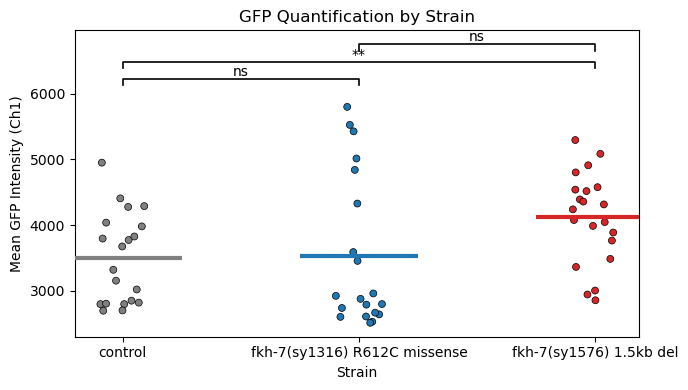

In [41]:
# Cell 4: plotting
custom_color_map = {
    "control": "gray",
    "fkh-7(sy1316) R612C missense": "#1f77b4",
    "fkh-7(sy1576) 1.5kb del": "#d62728",
}

fig, ax = plt.subplots(figsize=(7, 4))


means_by_strain = (
    df.groupby("Strain")[INTENSITY_COL]
      .mean()
      .reindex(forced_order)
)


for i, strain in enumerate(forced_order):
    label = strain_label_map[strain]
    mean_val = means_by_strain[strain]
    ax.hlines(
        y=mean_val,
        xmin=i - 0.25,
        xmax=i + 0.25,
        colors=custom_color_map[label],
        linewidth=3,
        zorder=3
    )

sns.stripplot(
    data=df,
    x="Strain_display",
    y=INTENSITY_COL,  # <-- variable, no quotes
    order=display_order,
    palette=[custom_color_map[l] for l in display_order],
    jitter=True,
    dodge=False,
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    zorder=2
)

def p_to_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

comparisons = [(0, 1), (0, 2), (1, 2)]

y_min = df[INTENSITY_COL].min()
y_max = df[INTENSITY_COL].max()
y_range = y_max - y_min if y_max > y_min else 1.0

base_height = y_max + 0.1 * y_range
step = 0.08 * y_range

for j, (idx1, idx2) in enumerate(comparisons):
    strain1 = forced_order[idx1]
    strain2 = forced_order[idx2]

    vals1 = df.loc[df["Strain"] == strain1, INTENSITY_COL]
    vals2 = df.loc[df["Strain"] == strain2, INTENSITY_COL]

    t_stat, p_val = ttest_ind(vals1, vals2, equal_var=False, nan_policy="omit")
    stars = p_to_stars(p_val)

    x1, x2 = idx1, idx2
    y = base_height + j * step
    h = 0.03 * y_range

    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color="black", linewidth=1.2)
    ax.text((x1 + x2) / 2, y + h, stars, ha="center", va="bottom", fontsize=10)

ax.set_xlabel("Strain")
ax.set_ylabel("Mean GFP Intensity (Ch1)")
ax.set_title("GFP Quantification by Strain")

fig.tight_layout()
plt.show()


In [38]:
# Save fig

try:
    fig
except NameError:
    raise RuntimeError("Figure not found — run Cell 3 before trying to save.")

root = Tk()
root.withdraw()
save_path = filedialog.asksaveasfilename(
    title="Save figure as...",
    defaultextension=".png",
    filetypes=[
        ("PNG", "*.png"),
        ("PDF", "*.pdf"),
        ("SVG", "*.svg"),
        ("All files", "*.*")
    ]
)
root.update()
root.destroy()

if save_path:
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved figure to: {save_path}")
else:
    print("Save cancelled — figure was not written to disk.")


Saved figure to: C:/Users/Twolf/Documents/cynthia project/plots/20260127_gfp_quant_script003.png
